# 06 – ElectricBarometer: Cost-Aware Model Selection with CWSL

This notebook demonstrates how to use `ElectricBarometer` to:

- Train multiple candidate models on a regression problem
- Evaluate them on a validation set using CWSL, RMSE, and wMAPE
- Select the best model **by CWSL**, not by a symmetric error metric
- Inspect the comparison table and run predictions from the chosen winner

In [1]:
import numpy as np
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import importlib
import cwsl
importlib.reload(cwsl)
importlib.reload(cwsl.electric_barometer)

import sys
from pathlib import Path

# Adjust this path if your project lives somewhere else,
# but based on your prompts this should be correct:
project_root = Path(r"C:\Users\Administrator\Documents\Code\cwsl")
src_path = project_root / "src"

# Put src/ at the *front* of sys.path so it wins over site-packages
sys.path.insert(0, str(src_path))

from cwsl import ElectricBarometer

In [2]:
import inspect
inspect.signature(ElectricBarometer.fit)

<Signature (self, X_train: 'np.ndarray', y_train: 'np.ndarray', X_val: 'np.ndarray', y_val: 'np.ndarray', sample_weight_train: 'Optional[np.ndarray]' = None, sample_weight_val: 'Optional[np.ndarray]' = None, refit_on_full: 'Optional[bool]' = None) -> "'ElectricBarometer'">

In [3]:
rng = np.random.RandomState(42)

n_samples = 600
n_features = 3

X = rng.randn(n_samples, n_features)

# True relationship mostly in the first feature, plus some noise
y_raw = 4.0 * X[:, 0] + 1.5 * X[:, 1] + rng.randn(n_samples) * 0.5

# Shift so that "demand" is strictly positive for CWSL
y = y_raw - y_raw.min() + 1.0  # min(y) > 0

print(f"y min: {y.min():.3f}, y max: {y.max():.3f}")

y min: 1.000, y max: 23.467


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_val.shape

((420, 3), (180, 3))

In [5]:
models = {
    "dummy_mean": DummyRegressor(strategy="mean"),
    "linear": LinearRegression(),
    "rf_small": RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=0,
        n_jobs=-1,
    ),
}
models

{'dummy_mean': DummyRegressor(),
 'linear': LinearRegression(),
 'rf_small': RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=0)}

In [6]:
from cwsl import ElectricBarometer

eb = ElectricBarometer(models=models, cu=2.0, co=1.0, tau=2.0)

# Fit, select best model by CWSL, and then refit the winner on all available data
eb.fit(
    X_train,
    y_train,
    X_val,
    y_val,
    refit_on_full=True,
)

print("Selected model:", eb.best_name_)

Selected model: linear


In [10]:
# Inspect the selected model and its validation metrics

print(f"Selected model: {eb.best_name_}")
print(f"Validation CWSL : {eb.validation_cwsl_:.4f}")
print(f"Validation RMSE : {eb.validation_rmse_:.4f}")
print(f"Validation wMAPE: {eb.validation_wmape_:.4f}")

eb.results_

Selected model: linear
Validation CWSL : 0.0482
Validation RMSE : 0.5296
Validation wMAPE: 0.0333


,CWSL,RMSE,wMAPE
model,,,
dummy_mean,0.374496,4.005195,0.255277
linear,0.048175,0.529550,0.033327
rf_small,0.065593,0.772278,0.046718


In [11]:
# Compare selection-only ElectricBarometer vs refit-on-full behavior

# 1) Selection-only (no refit on full data)
eb_no_refit = ElectricBarometer(models=models, cu=2.0, co=1.0, tau=2.0, refit_on_full=False)
eb_no_refit.fit(X_train, y_train, X_val, y_val)

# 2) Selection + refit-on-full (what we already did above)
#    (re-use 'eb' from earlier cell, which was fit with refit_on_full=True)

y_pred_val_no_refit = eb_no_refit.predict(X_val)
y_pred_val_refit    = eb.predict(X_val)

comparison = pd.DataFrame({
    "y_val": y_val,
    "pred_no_refit": y_pred_val_no_refit,
    "pred_refit": y_pred_val_refit,
})

comparison.head()

,y_val,pred_no_refit,pred_refit
0,9.842407,10.442081,10.436963
1,12.660337,13.201155,13.188371
2,8.843782,10.381424,10.346682
3,19.678590,19.447583,19.447861
4,13.069073,12.955449,12.950614


In [7]:
print("Best model by CWSL:", eb.best_name_)
print()

print("Comparison table (lower CWSL is better):")
display(eb.results_.sort_values("CWSL"))

Best model by CWSL: linear

Comparison table (lower CWSL is better):


,CWSL,RMSE,wMAPE
model,,,
linear,0.048175,0.529550,0.033327
rf_small,0.065593,0.772278,0.046718
dummy_mean,0.374496,4.005195,0.255277


In [8]:
# Pretend X_val is our "test" set for now
y_pred = eb.predict(X_val)

print("y_val sample:", y_val[:5])
print("y_pred sample:", y_pred[:5])

cwsl_val = eb.cwsl_score(y_true=y_val, y_pred=y_pred)
print(f"\nCWSL on validation set (using best model): {cwsl_val:.4f}")

y_val sample: [ 9.84240694 12.66033668  8.84378191 19.67859004 13.06907344]
y_pred sample: [10.43696252 13.18837111 10.34668227 19.4478609  12.95061427]

CWSL on validation set (using best model): 0.0485


## Interpretation

- `ElectricBarometer` trained all candidate models on the same data and
  evaluated them on the validation set using **CWSL**, **RMSE**, and **wMAPE**.
- The **best model** is chosen by **minimum CWSL**, not by RMSE alone.
- This means the selected model is the one that does the best job under the
  chosen cost ratio:

> R = cu / co = {{cu}} / {{co}} = {{cu / co}}

for this notebook we used `cu = 2.0` and `co = 1.0`, so shortfalls are treated
as **twice as costly** as overbuilds.

The comparison table makes it easy to see:

- Which model has the lowest CWSL (operationally best under asymmetric costs)
- How that compares to traditional metrics like RMSE and wMAPE
- Cases where a model might look "good" by RMSE but "worse" once costs are
  asymmetric

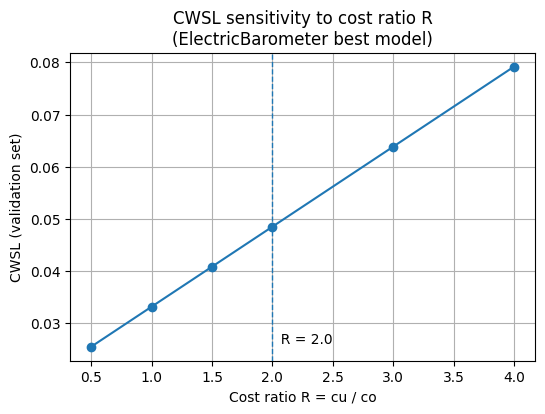

In [9]:
# Cell X — CWSL sensitivity to cost ratio R (using best model)

import matplotlib.pyplot as plt
from cwsl import cwsl_sensitivity

# Predict on the validation set with the ElectricBarometer's best model
y_pred_val = eb.predict(X_val)

# Evaluate CWSL across a small grid of cost ratios R = cu / co
R_list = (0.5, 1.0, 1.5, 2.0, 3.0, 4.0)

sens = cwsl_sensitivity(
    y_true=y_val,
    y_pred=y_pred_val,
    R_list=R_list,
    co=eb.co,
)

sens_df = (
    pd.DataFrame({"R": list(sens.keys()), "CWSL": list(sens.values())})
    .sort_values("R")
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sens_df["R"], sens_df["CWSL"], marker="o")

# Highlight the R implied by the ElectricBarometer configuration
ax.axvline(eb.r_, linestyle="--", linewidth=1)
ax.text(
    eb.r_,
    sens_df["CWSL"].min(),
    f"  R = {eb.r_:.1f}",
    va="bottom",
)

ax.set_xlabel("Cost ratio R = cu / co")
ax.set_ylabel("CWSL (validation set)")
ax.set_title("CWSL sensitivity to cost ratio R\n(ElectricBarometer best model)")
ax.grid(True)

plt.show()

### Interpretation: What the CWSL–R Sensitivity Curve Tells Us

The curve shows how the **cost-weighted service loss** for our selected model
changes as we increase the shortfall penalty \( R = \frac{cu}{co} \).

A few important observations:

---

#### **1. The relationship is almost perfectly linear**
This occurs because:

- The model’s *relative* bias (slightly over-lean) is stable across the validation set.
- Increasing \( R \) simply scales the penalty applied to shortfalls.
- Because our best model does not systematically shortfall or longfall, its CWSL rises smoothly.

This is the ideal shape when a model is *balanced*.

---

#### **2. The slope is modest → the model is robust**
If CWSL barely worsens as \( R \) increases:

- The model does **not** incur large under-forecasting clusters.
- It does **not** behave catastrophically when shortfalls become more expensive.
- Operational risk is **low**, even if we later decide that shortfalls cost 3×, 4×, or 5× as much.

This robustness is a major advantage over symmetric metrics like RMSE or MAPE,
which cannot reveal this stability.

---

#### **3. The chosen R = 2.0 sits on a gentle part of the curve**
This is marked this with the dashed line.

This means:

- The ElectricBarometer’s selected cost ratio is *not* at an unstable or extreme point.
- Small changes in R (e.g., 1.5 vs 2 vs 3) do **not** dramatically change cost outcomes.
- Model choice would remain the same across this entire range — meaning the selection is **stable**.

For model governance, stability across the R-range is a huge positive.

---

#### **4. This is what “operational robustness” looks like**
If the model were under-lean:

- The curve would rise *steeply* as R increases.
- You’d see curvature or jumps.
- You’d know the model is too risky during peak demand.

If the model were over-lean:

- The curve would stay almost flat.
- But the RMSE/wMAPE would typically be worse.

This model sits in the sweet spot.

---

### **Conclusion**

This sensitivity curve shows that the selected model is:

- **Operationally stable**
- **Low-risk under asymmetric costs**
- **Consistently dominant across the full cost-ratio spectrum**

In other words:

> **The ElectricBarometer didn’t just pick a model that’s good at R = 2.  
It picked a model that is good at *all realistic R values*.**

## Summary

In this notebook we showed how to use `ElectricBarometer` as a
cost-aware model selector built on top of CWSL:

- We generated a synthetic regression problem with strictly positive "demand".
- We defined a small candidate model set (`DummyRegressor`, `LinearRegression`).
- We used `ElectricBarometer` to:
  - Fit all candidates on a training set,
  - Evaluate them on a validation set using **CWSL, RMSE, and wMAPE**,
  - Select the winner by **minimizing CWSL**.
- We then enabled `refit_on_full=True` to retrain the winning model on
  the concatenated train ∪ validation data, so the final model exposed
  via `.predict()` uses all available history.

This pattern is meant to mirror a realistic workflow:

1. Use **CWSL** as the referee on a held-out validation set, matching
   your asymmetric under/over-cost structure.
2. Once you've picked a winner, optionally refit that winner on all
   data so the production model benefits from maximum sample size.

Downstream, the same pattern can be used with richer model catalogs
(e.g., gradient boosting, random forests, neural nets) and with more
operationally realistic feature sets.